In [1]:
import os
os.chdir("..")
from packages.data_objects.dataset import TorchH5Dataset, autoencoder_unpack_func
from packages.io.torch_dataloaders import get_data_loaders
dataset = TorchH5Dataset(h5_path='/media/lolly/SSD/motor_eeg_dataset/motor_eeg_dataset.h5', unpack_func=autoencoder_unpack_func)
train_loader, _, _ = get_data_loaders(dataset, norm_axes=(0,2), target_norm_axes=(0,2), norm_convergence_threshold=1e-3, batch_size=64, nsamples=1000)
batch = next(iter(train_loader))

Calculating normalization parameters (input & target):  98%|█████████▊| 39/40 [00:01<00:00, 31.68it/s, samples=5120, input_conv=0, target_conv=0]
/home/lolly/Projects/MIEEG/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


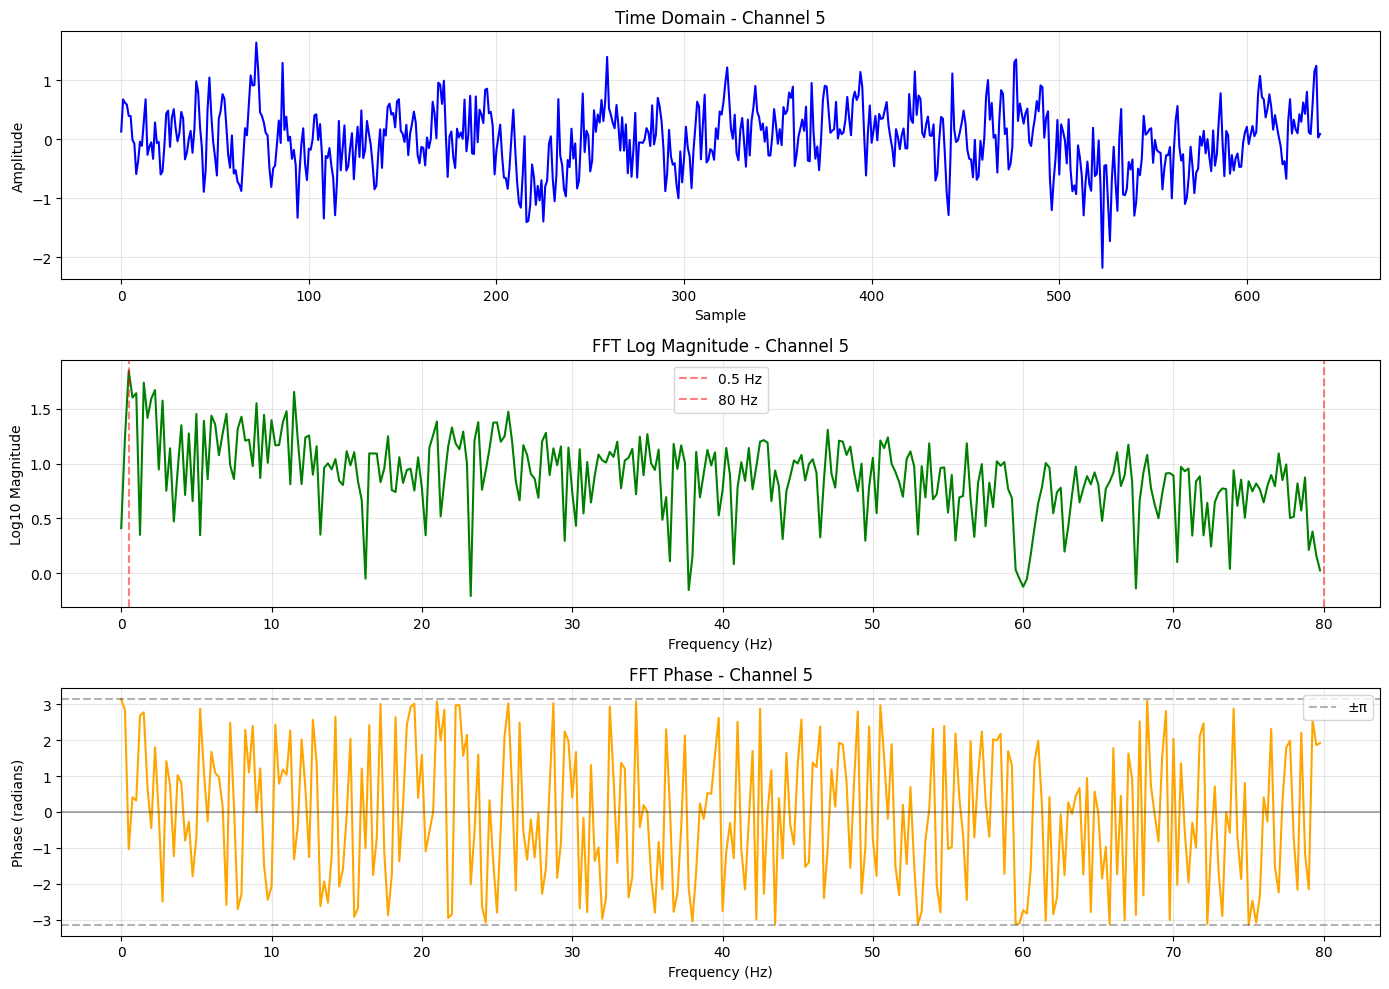


FFT STATISTICS - Channel 5
Signal length: 640 samples
Frequency resolution: 0.2500 Hz
Max frequency: 79.75 Hz

Magnitude:
  Min: 0.617359
  Max: 70.307098
  Mean: 10.416960

Phase:
  Min: -3.1380 rad (-179.79°)
  Max: 3.1416 rad (180.00°)
  Mean: -0.0899 rad (-5.15°)

Top 5 dominant frequencies:
  1. 0.50 Hz - Magnitude: 70.31
  2. 1.50 Hz - Magnitude: 54.96
  3. 2.25 Hz - Magnitude: 47.06
  4. 11.50 Hz - Magnitude: 45.23
  5. 1.00 Hz - Magnitude: 44.02


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Select a single channel
channel_idx = 5
signal = batch['input'][0][channel_idx]  # Shape: (640,) - single channel

# Compute FFT
fft_result = np.fft.fft(signal.numpy())
freqs = np.fft.fftfreq(signal.shape[0], d=1/160)  # d = 1/sampling_rate

# Get magnitude and phase
magnitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Only plot positive frequencies
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
magnitude_pos = magnitude[pos_mask]
phase_pos = phase[pos_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Time domain signal
axes[0].plot(signal.numpy(), linewidth=1.5, color='blue')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Time Domain - Channel {channel_idx}')
axes[0].grid(True, alpha=0.3)

# 2. Magnitude spectrum (log scale)
axes[1].plot(freqs_pos, np.log10(magnitude_pos + 1e-10), linewidth=1.5, color='green')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Log10 Magnitude')
axes[1].set_title(f'FFT Log Magnitude - Channel {channel_idx}')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='0.5 Hz')
axes[1].axvline(x=80, color='r', linestyle='--', alpha=0.5, label='80 Hz')
axes[1].legend()

# 3. Phase spectrum
axes[2].plot(freqs_pos, phase_pos, linewidth=1.5, color='orange')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Phase (radians)')
axes[2].set_title(f'FFT Phase - Channel {channel_idx}')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[2].axhline(y=np.pi, color='k', linestyle='--', alpha=0.3, label='±π')
axes[2].axhline(y=-np.pi, color='k', linestyle='--', alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"FFT STATISTICS - Channel {channel_idx}")
print(f"{'='*60}")
print(f"Signal length: {len(signal)} samples")
print(f"Frequency resolution: {freqs_pos[1] - freqs_pos[0]:.4f} Hz")
print(f"Max frequency: {freqs_pos[-1]:.2f} Hz")
print(f"\nMagnitude:")
print(f"  Min: {magnitude_pos.min():.6f}")
print(f"  Max: {magnitude_pos.max():.6f}")
print(f"  Mean: {magnitude_pos.mean():.6f}")
print(f"\nPhase:")
print(f"  Min: {phase_pos.min():.4f} rad ({np.degrees(phase_pos.min()):.2f}°)")
print(f"  Max: {phase_pos.max():.4f} rad ({np.degrees(phase_pos.max()):.2f}°)")
print(f"  Mean: {phase_pos.mean():.4f} rad ({np.degrees(phase_pos.mean()):.2f}°)")

# Find dominant frequencies
top_k = 5
peak_indices = np.argsort(magnitude_pos)[-top_k:][::-1]
print(f"\nTop {top_k} dominant frequencies:")
for i, idx in enumerate(peak_indices, 1):
    print(f"  {i}. {freqs_pos[idx]:.2f} Hz - Magnitude: {magnitude_pos[idx]:.2f}")
print(f"{'='*60}")

In [5]:
import torch
import numpy as np
from tqdm import tqdm

# ============================================================================
# BATCH CONSISTENCY CHECK
# ============================================================================

print("="*70)
print("CHECKING BATCH CONSISTENCY ACROSS DATASET")
print("="*70)

# Collect statistics from all batches
n_batches_to_check = min(100, len(train_loader))  # Check first 100 batches
print(f"\nAnalyzing {n_batches_to_check} batches...")

input_mins = []
input_maxs = []
input_means = []
input_stds = []
input_vars = []

target_mins = []
target_maxs = []
target_means = []
target_stds = []
target_vars = []

print("\nCollecting statistics...")
for i, batch in enumerate(tqdm(train_loader, total=n_batches_to_check, desc="Scanning batches")):
    if i >= n_batches_to_check:
        break
    
    # Input statistics
    input_data = batch['input']
    input_mins.append(input_data.min().item())
    input_maxs.append(input_data.max().item())
    input_means.append(input_data.mean().item())
    input_stds.append(input_data.std().item())
    input_vars.append(input_data.var().item())
    
    # Target statistics
    target_data = batch['target']
    target_mins.append(target_data.min().item())
    target_maxs.append(target_data.max().item())
    target_means.append(target_data.mean().item())
    target_stds.append(target_data.std().item())
    target_vars.append(target_data.var().item())

# Convert to arrays
input_mins = np.array(input_mins)
input_maxs = np.array(input_maxs)
input_means = np.array(input_means)
input_stds = np.array(input_stds)
input_vars = np.array(input_vars)

target_mins = np.array(target_mins)
target_maxs = np.array(target_maxs)
target_means = np.array(target_means)
target_stds = np.array(target_stds)
target_vars = np.array(target_vars)

# Print results
print("\n" + "="*70)
print("INPUT DATA STATISTICS")
print("="*70)
print(f"Min values across batches:")
print(f"  Global min: {input_mins.min():.6f}")
print(f"  Global max: {input_mins.max():.6f}")
print(f"  Mean: {input_mins.mean():.6f} ± {input_mins.std():.6f}")

print(f"\nMax values across batches:")
print(f"  Global min: {input_maxs.min():.6f}")
print(f"  Global max: {input_maxs.max():.6f}")
print(f"  Mean: {input_maxs.mean():.6f} ± {input_maxs.std():.6f}")

print(f"\nMean values across batches:")
print(f"  Min: {input_means.min():.6f}")
print(f"  Max: {input_means.max():.6f}")
print(f"  Mean: {input_means.mean():.6f} ± {input_means.std():.6f}")

print(f"\nStd values across batches:")
print(f"  Min: {input_stds.min():.6f}")
print(f"  Max: {input_stds.max():.6f}")
print(f"  Mean: {input_stds.mean():.6f} ± {input_stds.std():.6f}")

print(f"\nVariance values across batches:")
print(f"  Min: {input_vars.min():.6f}")
print(f"  Max: {input_vars.max():.6f}")
print(f"  Mean: {input_vars.mean():.6f} ± {input_vars.std():.6f}")

print("\n" + "="*70)
print("TARGET DATA STATISTICS")
print("="*70)
print(f"Min values across batches:")
print(f"  Global min: {target_mins.min():.6f}")
print(f"  Global max: {target_mins.max():.6f}")
print(f"  Mean: {target_mins.mean():.6f} ± {target_mins.std():.6f}")

print(f"\nMax values across batches:")
print(f"  Global min: {target_maxs.min():.6f}")
print(f"  Global max: {target_maxs.max():.6f}")
print(f"  Mean: {target_maxs.mean():.6f} ± {target_maxs.std():.6f}")

print(f"\nMean values across batches:")
print(f"  Min: {target_means.min():.6f}")
print(f"  Max: {target_means.max():.6f}")
print(f"  Mean: {target_means.mean():.6f} ± {target_means.std():.6f}")

print(f"\nStd values across batches:")
print(f"  Min: {target_stds.min():.6f}")
print(f"  Max: {target_stds.max():.6f}")
print(f"  Mean: {target_stds.mean():.6f} ± {target_stds.std():.6f}")

print(f"\nVariance values across batches:")
print(f"  Min: {target_vars.min():.6f}")
print(f"  Max: {target_vars.max():.6f}")
print(f"  Mean: {target_vars.mean():.6f} ± {target_vars.std():.6f}")

# Check for issues
print("\n" + "="*70)
print("CONSISTENCY CHECKS")
print("="*70)

issues = []

# Check 1: Normalization range
if input_mins.min() < -1.5 or input_maxs.max() > 1.5:
    issues.append("⚠ INPUT data is NOT normalized to [-1, 1] range!")
    print(f"✗ INPUT data range: [{input_mins.min():.3f}, {input_maxs.max():.3f}]")
else:
    print(f"✓ INPUT data properly normalized: [{input_mins.min():.3f}, {input_maxs.max():.3f}]")

if target_mins.min() < -1.5 or target_maxs.max() > 1.5:
    issues.append("⚠ TARGET data is NOT normalized to [-1, 1] range!")
    print(f"✗ TARGET data range: [{target_mins.min():.3f}, {target_maxs.max():.3f}]")
else:
    print(f"✓ TARGET data properly normalized: [{target_mins.min():.3f}, {target_maxs.max():.3f}]")

# Check 2: Mean near zero
if abs(input_means.mean()) > 0.1:
    issues.append(f"⚠ INPUT mean is far from 0: {input_means.mean():.6f}")
    print(f"✗ INPUT mean: {input_means.mean():.6f} (should be ~0)")
else:
    print(f"✓ INPUT mean centered: {input_means.mean():.6f}")

if abs(target_means.mean()) > 0.1:
    issues.append(f"⚠ TARGET mean is far from 0: {target_means.mean():.6f}")
    print(f"✗ TARGET mean: {target_means.mean():.6f} (should be ~0)")
else:
    print(f"✓ TARGET mean centered: {target_means.mean():.6f}")

# Check 3: Std consistency across batches
if input_stds.std() > 0.2:
    issues.append(f"⚠ INPUT std varies too much across batches: {input_stds.std():.6f}")
    print(f"✗ INPUT std variation: {input_stds.std():.6f} (should be < 0.2)")
else:
    print(f"✓ INPUT std consistent: {input_stds.std():.6f}")

if target_stds.std() > 0.2:
    issues.append(f"⚠ TARGET std varies too much across batches: {target_stds.std():.6f}")
    print(f"✗ TARGET std variation: {target_stds.std():.6f} (should be < 0.2)")
else:
    print(f"✓ TARGET std consistent: {target_stds.std():.6f}")

# Check 4: Variance consistency
if input_vars.std() / input_vars.mean() > 0.3:  # Coefficient of variation
    issues.append(f"⚠ INPUT variance varies too much: CV={input_vars.std()/input_vars.mean():.3f}")
    print(f"✗ INPUT variance CV: {input_vars.std()/input_vars.mean():.3f} (should be < 0.3)")
else:
    print(f"✓ INPUT variance consistent: CV={input_vars.std()/input_vars.mean():.3f}")

if target_vars.std() / target_vars.mean() > 0.3:
    issues.append(f"⚠ TARGET variance varies too much: CV={target_vars.std()/target_vars.mean():.3f}")
    print(f"✗ TARGET variance CV: {target_vars.std()/target_vars.mean():.3f} (should be < 0.3)")
else:
    print(f"✓ TARGET variance consistent: CV={target_vars.std()/target_vars.mean():.3f}")

# Check 5: Input/Target mismatch
if abs(input_means.mean() - target_means.mean()) > 0.1:
    issues.append("⚠ INPUT and TARGET have different mean values!")
    print(f"✗ Mean mismatch: Input={input_means.mean():.6f}, Target={target_means.mean():.6f}")
else:
    print(f"✓ INPUT/TARGET means match")

if abs(input_vars.mean() - target_vars.mean()) / max(input_vars.mean(), target_vars.mean()) > 0.2:
    issues.append("⚠ INPUT and TARGET have different variance!")
    print(f"✗ Variance mismatch: Input={input_vars.mean():.6f}, Target={target_vars.mean():.6f}")
else:
    print(f"✓ INPUT/TARGET variances match")

# Check 6: Initial MSE sanity
sample_batch = next(iter(train_loader))
initial_mse = torch.nn.functional.mse_loss(
    sample_batch['input'], 
    sample_batch['target']
).item()
print(f"\nInitial MSE (input vs target): {initial_mse:.6f}")

if initial_mse > 0.01:
    issues.append(f"⚠ Input and target are different! MSE={initial_mse:.6f}")
    print("✗ INPUT ≠ TARGET (this is expected for denoising tasks)")
else:
    print("✓ INPUT ≈ TARGET (reconstruction task)")

# Final diagnosis
print("\n" + "="*70)
print("DIAGNOSIS")
print("="*70)

if len(issues) == 0:
    print("✓ ALL CHECKS PASSED - Data normalization is consistent!")
    print("  → If training is still slow, issue is in model/optimizer")
else:
    print(f"✗ FOUND {len(issues)} ISSUE(S):")
    for issue in issues:
        print(f"  {issue}")
    print("\n  → Fix normalization before training!")

# Additional helpful info
print("\n" + "="*70)
print("SAMPLE BATCH INFO")
print("="*70)
sample_batch = next(iter(train_loader))
print(f"Batch size: {sample_batch['input'].shape[0]}")
print(f"Input shape: {sample_batch['input'].shape}")
print(f"Target shape: {sample_batch['target'].shape}")
print(f"Input dtype: {sample_batch['input'].dtype}")
print(f"Target dtype: {sample_batch['target'].dtype}")

# Detailed variance analysis
print("\n" + "="*70)
print("VARIANCE ANALYSIS")
print("="*70)
print(f"Input  variance: {input_vars.mean():.6f} (range: [{input_vars.min():.6f}, {input_vars.max():.6f}])")
print(f"Target variance: {target_vars.mean():.6f} (range: [{target_vars.min():.6f}, {target_vars.max():.6f}])")
print(f"Variance ratio (input/target): {input_vars.mean() / target_vars.mean():.3f}")

# Expected variance for normalized data
expected_var_normalized = 1.0  # For data normalized to ~N(0,1)
print(f"\nExpected variance for normalized data: ~{expected_var_normalized:.1f}")
print(f"Input variance deviation: {abs(input_vars.mean() - expected_var_normalized):.3f}")
print(f"Target variance deviation: {abs(target_vars.mean() - expected_var_normalized):.3f}")

print("\n" + "="*70)

CHECKING BATCH CONSISTENCY ACROSS DATASET

Analyzing 10 batches...



Scanning batches:   0%|          | 0/10 [00:00<?, ?it/s]

Scanning batches: 100%|██████████| 10/10 [00:00<00:00, 58.45it/s]


INPUT DATA STATISTICS
Min values across batches:
  Global min: -21.628815
  Global max: -6.726975
  Mean: -14.504405 ± 4.355075

Max values across batches:
  Global min: 10.099248
  Global max: 25.393141
  Mean: 16.486705 ± 4.272404

Mean values across batches:
  Min: -0.003189
  Max: 0.002148
  Mean: -0.000425 ± 0.001682

Std values across batches:
  Min: 0.862630
  Max: 1.124073
  Mean: 0.997759 ± 0.082028

Variance values across batches:
  Min: 0.744130
  Max: 1.263540
  Mean: 1.002252 ± 0.163181

TARGET DATA STATISTICS
Min values across batches:
  Global min: -21.628815
  Global max: -6.726975
  Mean: -14.504405 ± 4.355075

Max values across batches:
  Global min: 10.099248
  Global max: 25.393141
  Mean: 16.486705 ± 4.272404

Mean values across batches:
  Min: -0.003189
  Max: 0.002148
  Mean: -0.000425 ± 0.001682

Std values across batches:
  Min: 0.862630
  Max: 1.124073
  Mean: 0.997759 ± 0.082028

Variance values across batches:
  Min: 0.744130
  Max: 1.263540
  Mean: 1.00225


Initial MSE (input vs target): 0.000000
✓ INPUT ≈ TARGET (reconstruction task)

DIAGNOSIS
✗ FOUND 2 ISSUE(S):
  ⚠ INPUT data is NOT normalized to [-1, 1] range!
  ⚠ TARGET data is NOT normalized to [-1, 1] range!

  → Fix normalization before training!

SAMPLE BATCH INFO
Batch size: 64
Input shape: torch.Size([64, 32, 640])
Target shape: torch.Size([64, 32, 640])
Input dtype: torch.float32
Target dtype: torch.float32

VARIANCE ANALYSIS
Input  variance: 1.002252 (range: [0.744130, 1.263540])
Target variance: 1.002252 (range: [0.744130, 1.263540])
Variance ratio (input/target): 1.000

Expected variance for normalized data: ~1.0
Input variance deviation: 0.002
Target variance deviation: 0.002



In [2]:
from packages.models.vqae_light_ts import VQAELight, VQAELightConfig
from packages.train.loss import CWTLoss

config = VQAELightConfig(embedding_dim=128, 
                         use_quantizer=False
                         )
model = VQAELight(config)
loss_fn = CWTLoss()

In [6]:
from packages.train.loss import CustomMSE

from packages.models.vqae_light import VQAELight, VQAELightConfig
config = VQAELightConfig(embedding_dim=128, 
                         use_quantizer=False
                         )
model = VQAELight(config)
loss_fn = CustomMSE()

In [8]:
from packages.train.loss import CustomMSE

from packages.models.vqae_23 import VQAE23, VQAE23Config
config = VQAE23Config(embedding_dim=128, 
                         use_quantizer=False
                         )
model = VQAE23(config)
loss_fn = CustomMSE()

In [4]:
import torch
import numpy as np
from tqdm import tqdm

# ============================================================================
# CWT HEAD OUTPUT STATISTICS - POWER & PHASE ANALYSIS
# ============================================================================

print("="*70)
print("CWT HEAD OUTPUT STATISTICS - POWER & PHASE ANALYSIS")
print("="*70)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Collect CWT output statistics across batches
n_batches_to_check = min(50, len(train_loader))
print(f"\nAnalyzing CWT head output from {n_batches_to_check} batches...\n")

# Separate storage for power (channel 0) and phase (channel 1)
power_mins, power_maxs, power_means, power_stds, power_vars = [], [], [], [], []
phase_mins, phase_maxs, phase_means, phase_stds, phase_vars = [], [], [], [], []
cwt_shapes = []

with torch.no_grad():
    for i, batch in enumerate(tqdm(train_loader, total=n_batches_to_check, desc="Processing batches")):
        if i >= n_batches_to_check:
            break
        
        # Move to device
        input_data = batch['input'].to(device)
        
        # Get CWT head output
        cwt_output = model.cwt_head(input_data)
        
        # Split into power and phase
        power_output = cwt_output[:, 0, :, :]  # Channel 0: Power
        phase_output = cwt_output[:, 1, :, :]  # Channel 1: Phase
        
        # Collect power statistics
        power_mins.append(power_output.min().item())
        power_maxs.append(power_output.max().item())
        power_means.append(power_output.mean().item())
        power_stds.append(power_output.std().item())
        power_vars.append(power_output.var().item())
        
        # Collect phase statistics
        phase_mins.append(phase_output.min().item())
        phase_maxs.append(phase_output.max().item())
        phase_means.append(phase_output.mean().item())
        phase_stds.append(phase_output.std().item())
        phase_vars.append(phase_output.var().item())
        
        cwt_shapes.append(tuple(cwt_output.shape))

# Convert to arrays
power_mins = np.array(power_mins)
power_maxs = np.array(power_maxs)
power_means = np.array(power_means)
power_stds = np.array(power_stds)
power_vars = np.array(power_vars)

phase_mins = np.array(phase_mins)
phase_maxs = np.array(phase_maxs)
phase_means = np.array(phase_means)
phase_stds = np.array(phase_stds)
phase_vars = np.array(phase_vars)

# ============================================================================
# POWER CHANNEL ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("POWER CHANNEL (Channel 0) STATISTICS")
print("="*70)

print(f"\nOutput Shape: {cwt_shapes[0]}")
print(f"  (Batch, 2, Freq_bands, Time)")
print(f"  → Analyzing channel 0: POWER")

print(f"\nMin values across batches:")
print(f"  Global min: {power_mins.min():.6f}")
print(f"  Global max: {power_mins.max():.6f}")
print(f"  Mean: {power_mins.mean():.6f} ± {power_mins.std():.6f}")

print(f"\nMax values across batches:")
print(f"  Global min: {power_maxs.min():.6f}")
print(f"  Global max: {power_maxs.max():.6f}")
print(f"  Mean: {power_maxs.mean():.6f} ± {power_maxs.std():.6f}")

print(f"\nMean values across batches:")
print(f"  Min: {power_means.min():.6f}")
print(f"  Max: {power_means.max():.6f}")
print(f"  Mean: {power_means.mean():.6f} ± {power_means.std():.6f}")

print(f"\nStd values across batches:")
print(f"  Min: {power_stds.min():.6f}")
print(f"  Max: {power_stds.max():.6f}")
print(f"  Mean: {power_stds.mean():.6f} ± {power_stds.std():.6f}")

print(f"\nVariance values across batches:")
print(f"  Min: {power_vars.min():.6f}")
print(f"  Max: {power_vars.max():.6f}")
print(f"  Mean: {power_vars.mean():.6f} ± {power_vars.std():.6f}")

# ============================================================================
# PHASE CHANNEL ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("PHASE CHANNEL (Channel 1) STATISTICS")
print("="*70)

print(f"\nOutput Shape: {cwt_shapes[0]}")
print(f"  (Batch, 2, Freq_bands, Time)")
print(f"  → Analyzing channel 1: PHASE")

print(f"\nMin values across batches:")
print(f"  Global min: {phase_mins.min():.6f}")
print(f"  Global max: {phase_mins.max():.6f}")
print(f"  Mean: {phase_mins.mean():.6f} ± {phase_mins.std():.6f}")

print(f"\nMax values across batches:")
print(f"  Global min: {phase_maxs.min():.6f}")
print(f"  Global max: {phase_maxs.max():.6f}")
print(f"  Mean: {phase_maxs.mean():.6f} ± {phase_maxs.std():.6f}")

print(f"\nMean values across batches:")
print(f"  Min: {phase_means.min():.6f}")
print(f"  Max: {phase_means.max():.6f}")
print(f"  Mean: {phase_means.mean():.6f} ± {phase_means.std():.6f}")

print(f"\nStd values across batches:")
print(f"  Min: {phase_stds.min():.6f}")
print(f"  Max: {phase_stds.max():.6f}")
print(f"  Mean: {phase_stds.mean():.6f} ± {phase_stds.std():.6f}")

print(f"\nVariance values across batches:")
print(f"  Min: {phase_vars.min():.6f}")
print(f"  Max: {phase_vars.max():.6f}")
print(f"  Mean: {phase_vars.mean():.6f} ± {phase_vars.std():.6f}")

# ============================================================================
# DETAILED DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("DETAILED DISTRIBUTION ANALYSIS")
print("="*70)

# Get a sample for detailed analysis
sample_batch = next(iter(train_loader))
sample_input = sample_batch['input'].to(device)
with torch.no_grad():
    sample_cwt = model.cwt_head(sample_input).cpu().numpy()

sample_power = sample_cwt[:, 0, :, :]  # Power channel
sample_phase = sample_cwt[:, 1, :, :]  # Phase channel

# Power distribution
print("\n--- POWER CHANNEL DISTRIBUTION ---")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"Percentiles:")
for p in percentiles:
    val = np.percentile(sample_power, p)
    print(f"  {p:2d}th: {val:8.4f}")

# Check for special values in power
n_zeros_power = np.sum(sample_power == 0)
n_nans_power = np.sum(np.isnan(sample_power))
n_infs_power = np.sum(np.isinf(sample_power))
n_total_power = sample_power.size

print(f"\nSpecial values in POWER:")
print(f"  Zeros: {n_zeros_power:,} ({100*n_zeros_power/n_total_power:.2f}%)")
print(f"  NaNs:  {n_nans_power:,} ({100*n_nans_power/n_total_power:.2f}%)")
print(f"  Infs:  {n_infs_power:,} ({100*n_infs_power/n_total_power:.2f}%)")

# Phase distribution
print("\n--- PHASE CHANNEL DISTRIBUTION ---")
print(f"Percentiles:")
for p in percentiles:
    val = np.percentile(sample_phase, p)
    print(f"  {p:2d}th: {val:8.4f}")

# Check for special values in phase
n_zeros_phase = np.sum(sample_phase == 0)
n_nans_phase = np.sum(np.isnan(sample_phase))
n_infs_phase = np.sum(np.isinf(sample_phase))
n_total_phase = sample_phase.size

print(f"\nSpecial values in PHASE:")
print(f"  Zeros: {n_zeros_phase:,} ({100*n_zeros_phase/n_total_phase:.2f}%)")
print(f"  NaNs:  {n_nans_phase:,} ({100*n_nans_phase/n_total_phase:.2f}%)")
print(f"  Infs:  {n_infs_phase:,} ({100*n_infs_phase/n_total_phase:.2f}%)")

# ============================================================================
# PER-FREQUENCY BAND ANALYSIS (POWER vs PHASE)
# ============================================================================
print("\n" + "="*70)
print("PER-FREQUENCY BAND ANALYSIS")
print("="*70)

n_freq_bands = sample_power.shape[1]
print(f"\nNumber of frequency bands: {n_freq_bands}")

# Statistics per frequency band for power
power_band_means = sample_power.mean(axis=(0, 2))  # Average over batch, time
power_band_stds = sample_power.std(axis=(0, 2))
power_band_mins = np.min(sample_power, axis=(0, 2))
power_band_maxs = np.max(sample_power, axis=(0, 2))

# Statistics per frequency band for phase
phase_band_means = sample_phase.mean(axis=(0, 2))
phase_band_stds = sample_phase.std(axis=(0, 2))
phase_band_mins = np.min(sample_phase, axis=(0, 2))
phase_band_maxs = np.max(sample_phase, axis=(0, 2))

print(f"\n--- POWER CHANNEL ---")
print(f"{'Band':<6} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-" * 50)
for i in range(min(10, n_freq_bands)):
    print(f"{i:<6} {power_band_means[i]:<10.4f} {power_band_stds[i]:<10.4f} "
          f"{power_band_mins[i]:<10.4f} {power_band_maxs[i]:<10.4f}")
if n_freq_bands > 10:
    print(f"... ({n_freq_bands - 10} more bands)")

print(f"\n--- PHASE CHANNEL ---")
print(f"{'Band':<6} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-" * 50)
for i in range(min(10, n_freq_bands)):
    print(f"{i:<6} {phase_band_means[i]:<10.4f} {phase_band_stds[i]:<10.4f} "
          f"{phase_band_mins[i]:<10.4f} {phase_band_maxs[i]:<10.4f}")
if n_freq_bands > 10:
    print(f"... ({n_freq_bands - 10} more bands)")

# ============================================================================
# CONSISTENCY CHECKS
# ============================================================================
print("\n" + "="*70)
print("CONSISTENCY CHECKS")
print("="*70)

issues = []

# Check 1: Power channel value range
print("\n--- POWER CHANNEL ---")
if power_mins.min() < -10 or power_maxs.max() > 10:
    issues.append(f"⚠ POWER values outside typical range: [{power_mins.min():.3f}, {power_maxs.max():.3f}]")
    print(f"✗ POWER range: [{power_mins.min():.3f}, {power_maxs.max():.3f}]")
else:
    print(f"✓ POWER range reasonable: [{power_mins.min():.3f}, {power_maxs.max():.3f}]")

# Check power mean (should be positive for power/magnitude)
if power_means.mean() < 0:
    issues.append(f"⚠ POWER mean is negative: {power_means.mean():.6f}")
    print(f"✗ POWER mean: {power_means.mean():.6f} (should be positive)")
else:
    print(f"✓ POWER mean positive: {power_means.mean():.6f}")

# Check power consistency
if power_stds.std() / power_stds.mean() > 0.5:
    issues.append(f"⚠ POWER std varies too much: CV={power_stds.std()/power_stds.mean():.3f}")
    print(f"✗ POWER std CV: {power_stds.std()/power_stds.mean():.3f} (should be < 0.5)")
else:
    print(f"✓ POWER std consistent: CV={power_stds.std()/power_stds.mean():.3f}")

# Check 2: Phase channel value range
print("\n--- PHASE CHANNEL ---")
if phase_mins.min() < -np.pi - 0.5 or phase_maxs.max() > np.pi + 0.5:
    issues.append(f"⚠ PHASE values outside typical range: [{phase_mins.min():.3f}, {phase_maxs.max():.3f}]")
    print(f"⚠ PHASE range: [{phase_mins.min():.3f}, {phase_maxs.max():.3f}]")
    print(f"  (Expected: approximately [-π, π] = [-3.14, 3.14])")
else:
    print(f"✓ PHASE range reasonable: [{phase_mins.min():.3f}, {phase_maxs.max():.3f}]")
    print(f"  (Expected: [-π, π] = [-3.14, 3.14])")

# Check phase mean (should be near zero)
if abs(phase_means.mean()) > 1.0:
    issues.append(f"⚠ PHASE mean is far from 0: {phase_means.mean():.6f}")
    print(f"⚠ PHASE mean: {phase_means.mean():.6f} (expected ~0)")
else:
    print(f"✓ PHASE mean centered: {phase_means.mean():.6f}")

# Check phase consistency
if phase_stds.std() / phase_stds.mean() > 0.5:
    issues.append(f"⚠ PHASE std varies too much: CV={phase_stds.std()/phase_stds.mean():.3f}")
    print(f"✗ PHASE std CV: {phase_stds.std()/phase_stds.mean():.3f} (should be < 0.5)")
else:
    print(f"✓ PHASE std consistent: CV={phase_stds.std()/phase_stds.mean():.3f}")

# Check 3: NaN/Inf check
print("\n--- SPECIAL VALUES ---")
if n_nans_power > 0 or n_infs_power > 0:
    issues.append(f"⚠ Found {n_nans_power} NaNs and {n_infs_power} Infs in POWER!")
    print(f"✗ Invalid values in POWER!")
else:
    print(f"✓ No NaN/Inf in POWER")

if n_nans_phase > 0 or n_infs_phase > 0:
    issues.append(f"⚠ Found {n_nans_phase} NaNs and {n_infs_phase} Infs in PHASE!")
    print(f"✗ Invalid values in PHASE!")
else:
    print(f"✓ No NaN/Inf in PHASE")

# ============================================================================
# POWER/PHASE RELATIONSHIP ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("POWER/PHASE RELATIONSHIP ANALYSIS")
print("="*70)

# Correlation between power and phase variability
print(f"\nVariance comparison:")
print(f"  POWER variance: {power_vars.mean():.6f} ± {power_vars.std():.6f}")
print(f"  PHASE variance: {phase_vars.mean():.6f} ± {phase_vars.std():.6f}")
print(f"  Ratio (Power/Phase): {power_vars.mean() / phase_vars.mean():.3f}")

# Dynamic range comparison
power_range = power_maxs.mean() - power_mins.mean()
phase_range = phase_maxs.mean() - phase_mins.mean()
print(f"\nDynamic range:")
print(f"  POWER: {power_range:.3f}")
print(f"  PHASE: {phase_range:.3f}")
print(f"  Ratio (Power/Phase): {power_range / phase_range:.3f}")

# ============================================================================
# FINAL DIAGNOSIS
# ============================================================================
print("\n" + "="*70)
print("DIAGNOSIS")
print("="*70)

if len(issues) == 0:
    print("✓ POWER & PHASE CHANNELS LOOK HEALTHY")
    print("  → Both channels are stable and consistent")
else:
    print(f"⚠ FOUND {len(issues)} ISSUE(S):")
    for issue in issues:
        print(f"  {issue}")

# Specific recommendations
print("\n📊 RECOMMENDATIONS:")
if power_means.mean() < 0.1:
    print("  ⚠ POWER values are very small - may need scaling")
if abs(phase_means.mean()) > 0.5:
    print("  ⚠ PHASE is not centered - check phase unwrapping")
if power_vars.mean() / phase_vars.mean() > 10:
    print("  ⚠ POWER has much higher variance than PHASE - may dominate gradients")
if power_vars.mean() / phase_vars.mean() < 0.1:
    print("  ⚠ PHASE has much higher variance than POWER - may dominate gradients")

print("\n" + "="*70)

CWT HEAD OUTPUT STATISTICS - POWER & PHASE ANALYSIS

Analyzing CWT head output from 50 batches...



Processing batches: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it]



POWER CHANNEL (Channel 0) STATISTICS

Output Shape: (256, 2, 25, 7, 5, 160)
  (Batch, 2, Freq_bands, Time)
  → Analyzing channel 0: POWER

Min values across batches:
  Global min: -3.382549
  Global max: -3.382545
  Mean: -3.382548 ± 0.000001

Max values across batches:
  Global min: 0.212373
  Global max: 0.432624
  Mean: 0.297231 ± 0.049064

Mean values across batches:
  Min: -1.670372
  Max: -1.664473
  Mean: -1.667486 ± 0.001484

Std values across batches:
  Min: 1.016514
  Max: 1.016667
  Mean: 1.016586 ± 0.000035

Variance values across batches:
  Min: 1.033301
  Max: 1.033611
  Mean: 1.033447 ± 0.000070

PHASE CHANNEL (Channel 1) STATISTICS

Output Shape: (256, 2, 25, 7, 5, 160)
  (Batch, 2, Freq_bands, Time)
  → Analyzing channel 1: PHASE

Min values across batches:
  Global min: -1.000000
  Global max: -1.000000
  Mean: -1.000000 ± 0.000000

Max values across batches:
  Global min: 1.000000
  Global max: 1.000000
  Mean: 1.000000 ± 0.000000

Mean values across batches:
  Min:

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [3]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# ============================================================================
# OVERFITTING TEST - Single Sample
# ============================================================================
nsamples = 1
print("="*70)
print(f"OVERFITTING TEST: Can the model memorize {nsamples} sample?")
print("="*70)

# Get a SINGLE sample (not batch)
input_data = batch['input'][0:nsamples]   # Shape: (1, 32, 640)
target_data = batch['target'][0:nsamples] # Shape: (1, 32, 640)

print(f"\nInput shape: {input_data.shape}")
print(f"Target shape: {target_data.shape}")
print(f"Input range: [{input_data.min():.3f}, {input_data.max():.3f}]")

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = model.to(device)
input_data = input_data.to(device)
target_data = target_data.to(device)

# CRITICAL: High LR for overfitting test
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training config
n_iterations = 500  # Should converge in <200 if model is good
log_every = 50

print(f"\nTraining for {n_iterations} iterations...")
print(f"Expected: MSE < 0.01 by iteration 200 (bottleneck=1024)")
print(f"Expected: MSE < 0.05 by iteration 200 (bottleneck=256)")
print(f"Expected: MSE < 0.10 by iteration 500 (bottleneck=64)")
print("="*70)

model.train()
best_mse = float('inf')
convergence_iter = None

for i in tqdm(range(n_iterations), desc="Overfitting"):
    # Forward pass
    optimizer.zero_grad()
    output = model(input_data)
    
    # Calculate loss
    recon_loss = loss_fn(output, {'target': target_data, 'input': input_data})
    
    # Backward pass
    recon_loss['loss'].backward()
    optimizer.step()
    
    # Track MSE
    current_mse = loss_fn(output, {'target': target_data, 'input': input_data})
    current_mse = current_mse['loss']
    # Track convergence
    if current_mse < best_mse:
        best_mse = current_mse
    
    if convergence_iter is None and current_mse < 0.01:
        convergence_iter = i + 1
    
    # Log progress
    if (i + 1) % log_every == 0:
        print(f"\n{'='*70}")
        print(f"Iteration {i+1}/{n_iterations}")
        print(f"{'='*70}")
        print(f"  MSE Loss: {current_mse:.6f}")
        print(f"  Total Loss: {recon_loss['loss'].item():.6f}")
        print(f"  Best MSE so far: {best_mse:.6f}")
        
        # Reconstruction quality check
        if current_mse < 0.001:
            print("  ✓ EXCELLENT: Near-perfect reconstruction!")
        elif current_mse < 0.01:
            print("  ✓ GOOD: Model has sufficient capacity")
        elif current_mse < 0.05:
            print("  ~ OK: Model learning but may need more capacity")
        elif current_mse < 0.1:
            print("  ⚠ SLOW: Bottleneck may be too small")
        else:
            print("  ✗ PROBLEM: Model struggling to overfit!")

print("\n" + "="*70)
print("OVERFITTING TEST COMPLETE")
print("="*70)
print(f"Final MSE: {best_mse:.6f}")

if convergence_iter:
    print(f"Converged to MSE < 0.01 at iteration: {convergence_iter}")
else:
    print("Did NOT converge to MSE < 0.01")

print("\n📊 DIAGNOSIS:")
if best_mse < 0.01:
    print("✓ Model has SUFFICIENT capacity for this task")
    print("  → If full training is slow, issue is likely:")
    print("    - Learning rate too low")
    print("    - Loss weights fighting each other")
    print("    - Data normalization issues")
elif best_mse < 0.05:
    print("~ Model has MODERATE capacity")
    print("  → Consider:")
    print(f"    - Increasing bottleneck dimension (current: {model.config.embedding_dim})")
    print("    - Increasing decoder width")
elif best_mse < 0.1:
    print("⚠ Model has LIMITED capacity")
    print("  → Bottleneck is too small - increase embedding_dim")
else:
    print("✗ Model CANNOT overfit - architectural problem")
    print("  → Check:")
    print("    - Decoder architecture (may be too weak)")
    print("    - Encoder/decoder shape mismatch")
    print("    - Gradient flow issues")

print("="*70)


OVERFITTING TEST: Can the model memorize 1 sample?

Input shape: torch.Size([1, 32, 640])
Target shape: torch.Size([1, 32, 640])
Input range: [-5.341, 3.543]
Device: cpu

Training for 500 iterations...
Expected: MSE < 0.01 by iteration 200 (bottleneck=1024)
Expected: MSE < 0.05 by iteration 200 (bottleneck=256)
Expected: MSE < 0.10 by iteration 500 (bottleneck=64)


Overfitting:  10%|█         | 50/500 [00:26<04:00,  1.87it/s]


Iteration 50/500
  MSE Loss: 0.370117
  Total Loss: 0.370117
  Best MSE so far: 0.370117
  ✗ PROBLEM: Model struggling to overfit!


Overfitting:  20%|██        | 100/500 [00:58<04:28,  1.49it/s]


Iteration 100/500
  MSE Loss: 0.370216
  Total Loss: 0.370216
  Best MSE so far: 0.369183
  ✗ PROBLEM: Model struggling to overfit!


Overfitting:  24%|██▍       | 120/500 [01:12<03:49,  1.66it/s]


KeyboardInterrupt: 

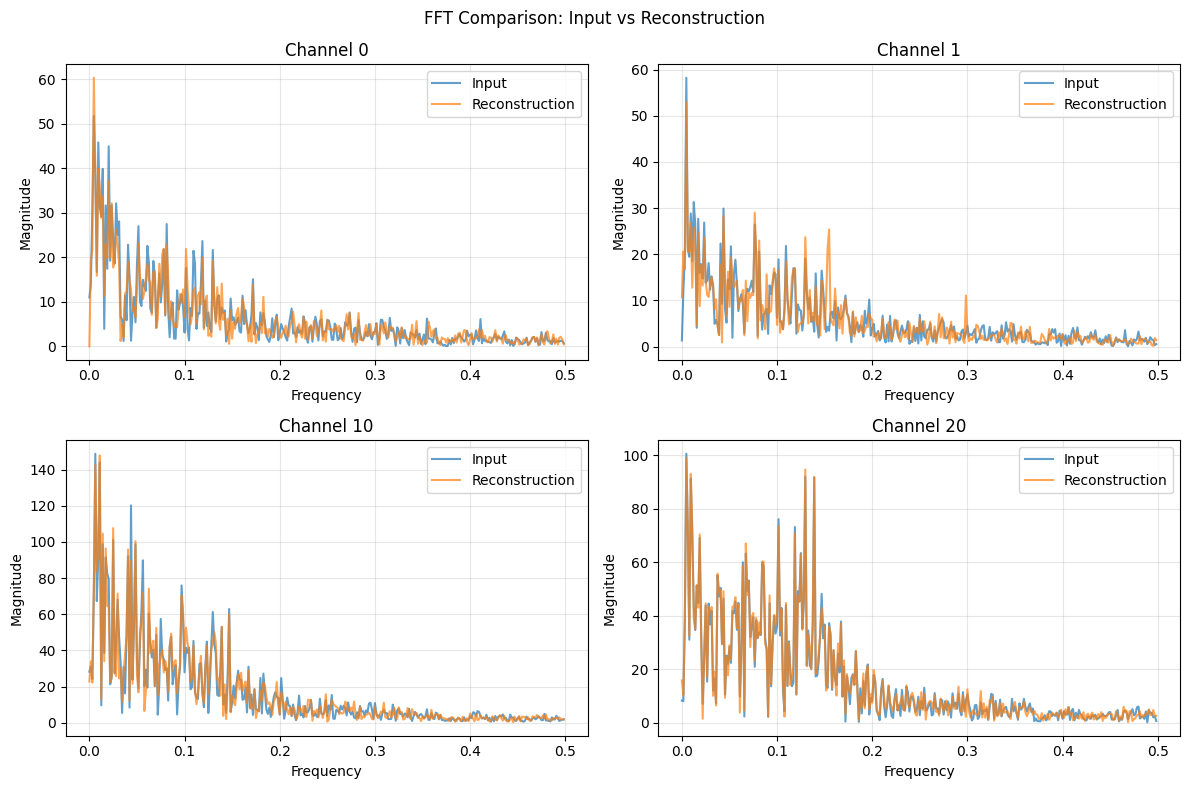

In [6]:
import numpy as np

import matplotlib.pyplot as plt

# Compute FFT for input and reconstruction
target_fft = np.fft.fft(target_data.squeeze().numpy(), axis=1)
recon_fft = np.fft.fft(recon.squeeze().numpy(), axis=1)

# Get frequencies
n_samples = target_data.shape[-1]
freqs = np.fft.fftfreq(n_samples)

# Plot magnitude spectrum for a few channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('FFT Comparison: Input vs Reconstruction')

channels_to_plot = [0, 1, 10, 20]  # Select a few channels to visualize

for idx, ch in enumerate(channels_to_plot):
    row = idx // 2
    col = idx % 2
    
    # Only plot positive frequencies
    pos_mask = freqs >= 0
    
    axes[row, col].plot(freqs[pos_mask], np.abs(target_fft[ch, pos_mask]), label='Input', alpha=0.7)
    axes[row, col].plot(freqs[pos_mask], np.abs(recon_fft[ch, pos_mask]), label='Reconstruction', alpha=0.7)
    axes[row, col].set_xlabel('Frequency')
    axes[row, col].set_ylabel('Magnitude')
    axes[row, col].set_title(f'Channel {ch}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

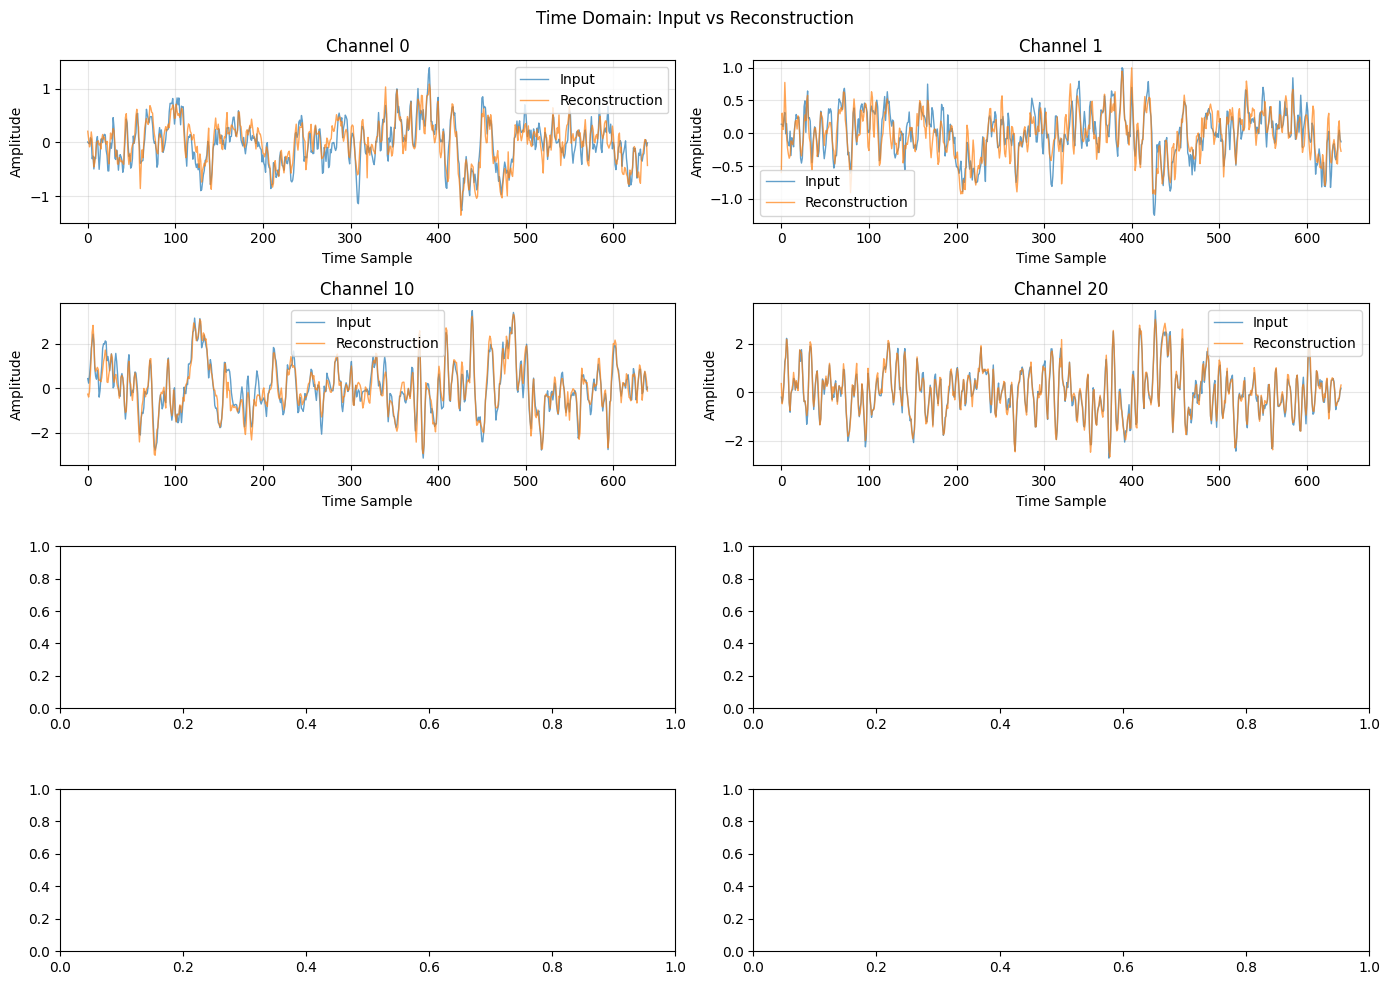

In [7]:
import matplotlib.pyplot as plt

# Plot time domain reconstruction vs input
fig, axes = plt.subplots(4, 2, figsize=(14, 10))
fig.suptitle('Time Domain: Input vs Reconstruction')

channels_to_plot = [0, 1, 10, 20]  # Use the same channels

for idx, ch in enumerate(channels_to_plot):
    row = idx // 2
    col = idx % 2
    
    # Plot input
    axes[row, col].plot(target_data.squeeze()[ch].numpy(), label='Input', alpha=0.7, linewidth=1)
    # Plot reconstruction
    axes[row, col].plot(recon.squeeze()[ch].numpy(), label='Reconstruction', alpha=0.7, linewidth=1)
    
    axes[row, col].set_xlabel('Time Sample')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].set_title(f'Channel {ch}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

from packages.train.loss import CustomMSE
# ============================================================================
# SINGLE BATCH SANITY CHECK
# ============================================================================

# Get a single batch

input_data = batch['input'][0].unsqueeze(0)  # Remove batch dimension
target_data = batch['target'][0].unsqueeze(0)  # Remove batch dimension

print(f"Input shape: {input_data.shape}")
print(f"Target shape: {target_data.shape}")

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_data = input_data.to(device)
target_data = target_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = CustomMSE()
# Training on single batch
n_iterations = 1000
model.train()

print(f"\nTraining on single batch for {n_iterations} iterations...")

for i in tqdm(range(n_iterations)):
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    output = model(input_data)
    
    # Calculate loss
    recon_loss = loss_fn(output, {'target': target_data, 'input': input_data})
    
    
    # 
    # Backward pass
    recon_loss['loss'].backward()
    optimizer.step()
    
    # Print every 10 iterations
    if (i + 1) % 10 == 0:
        print(f"\nIteration {i+1}/{n_iterations}")
        print(f"  Reconstruction Loss: {recon_loss}")
        # print(f"MSE Loss: {F.mse_loss(output['reconstruction'], target_data).item():.6f}")

print("\n✓ Sanity check complete!")
print(f"Final Reconstruction Loss: {recon_loss['loss'].item():.6f}")
print(f"Loss should be decreasing - model can overfit a single batch!")

Input shape: torch.Size([1, 32, 640])
Target shape: torch.Size([1, 32, 640])

Training on single batch for 1000 iterations...


  1%|          | 11/1000 [00:01<02:15,  7.28it/s]


Iteration 10/1000
  Reconstruction Loss: {'loss': tensor(1.6276, grad_fn=<MseLossBackward0>)}


  2%|▏         | 21/1000 [00:02<01:40,  9.75it/s]


Iteration 20/1000
  Reconstruction Loss: {'loss': tensor(1.5985, grad_fn=<MseLossBackward0>)}


  3%|▎         | 31/1000 [00:03<01:32, 10.45it/s]


Iteration 30/1000
  Reconstruction Loss: {'loss': tensor(1.5534, grad_fn=<MseLossBackward0>)}


  4%|▍         | 41/1000 [00:04<01:35, 10.02it/s]


Iteration 40/1000
  Reconstruction Loss: {'loss': tensor(1.4954, grad_fn=<MseLossBackward0>)}


  5%|▌         | 51/1000 [00:05<01:45,  9.00it/s]


Iteration 50/1000
  Reconstruction Loss: {'loss': tensor(1.4323, grad_fn=<MseLossBackward0>)}


  6%|▌         | 61/1000 [00:06<01:46,  8.86it/s]


Iteration 60/1000
  Reconstruction Loss: {'loss': tensor(1.3722, grad_fn=<MseLossBackward0>)}


  7%|▋         | 71/1000 [00:08<01:36,  9.63it/s]


Iteration 70/1000
  Reconstruction Loss: {'loss': tensor(1.3188, grad_fn=<MseLossBackward0>)}


  8%|▊         | 81/1000 [00:09<01:42,  8.98it/s]


Iteration 80/1000
  Reconstruction Loss: {'loss': tensor(1.2726, grad_fn=<MseLossBackward0>)}


  9%|▉         | 91/1000 [00:10<01:48,  8.35it/s]


Iteration 90/1000
  Reconstruction Loss: {'loss': tensor(1.2319, grad_fn=<MseLossBackward0>)}


 10%|█         | 101/1000 [00:11<01:38,  9.13it/s]


Iteration 100/1000
  Reconstruction Loss: {'loss': tensor(1.1965, grad_fn=<MseLossBackward0>)}


 11%|█         | 111/1000 [00:12<01:35,  9.35it/s]


Iteration 110/1000
  Reconstruction Loss: {'loss': tensor(1.1657, grad_fn=<MseLossBackward0>)}


 12%|█▏        | 121/1000 [00:13<01:36,  9.14it/s]


Iteration 120/1000
  Reconstruction Loss: {'loss': tensor(1.1378, grad_fn=<MseLossBackward0>)}


 13%|█▎        | 131/1000 [00:14<01:28,  9.84it/s]


Iteration 130/1000
  Reconstruction Loss: {'loss': tensor(1.1135, grad_fn=<MseLossBackward0>)}


 14%|█▍        | 141/1000 [00:15<01:22, 10.39it/s]


Iteration 140/1000
  Reconstruction Loss: {'loss': tensor(1.0922, grad_fn=<MseLossBackward0>)}


 15%|█▌        | 151/1000 [00:16<01:27,  9.65it/s]


Iteration 150/1000
  Reconstruction Loss: {'loss': tensor(1.0711, grad_fn=<MseLossBackward0>)}


 16%|█▌        | 161/1000 [00:18<02:13,  6.30it/s]


Iteration 160/1000
  Reconstruction Loss: {'loss': tensor(1.0527, grad_fn=<MseLossBackward0>)}


 17%|█▋        | 171/1000 [00:19<01:47,  7.75it/s]


Iteration 170/1000
  Reconstruction Loss: {'loss': tensor(1.0355, grad_fn=<MseLossBackward0>)}


 18%|█▊        | 181/1000 [00:20<01:44,  7.85it/s]


Iteration 180/1000
  Reconstruction Loss: {'loss': tensor(1.0213, grad_fn=<MseLossBackward0>)}


 19%|█▉        | 191/1000 [00:22<01:56,  6.94it/s]


Iteration 190/1000
  Reconstruction Loss: {'loss': tensor(1.0060, grad_fn=<MseLossBackward0>)}


 20%|██        | 201/1000 [00:23<01:53,  7.05it/s]


Iteration 200/1000
  Reconstruction Loss: {'loss': tensor(0.9930, grad_fn=<MseLossBackward0>)}


 21%|██        | 211/1000 [00:25<01:53,  6.96it/s]


Iteration 210/1000
  Reconstruction Loss: {'loss': tensor(0.9809, grad_fn=<MseLossBackward0>)}


 22%|██▏       | 221/1000 [00:26<01:56,  6.67it/s]


Iteration 220/1000
  Reconstruction Loss: {'loss': tensor(0.9716, grad_fn=<MseLossBackward0>)}


 23%|██▎       | 231/1000 [00:28<01:49,  7.00it/s]


Iteration 230/1000
  Reconstruction Loss: {'loss': tensor(0.9584, grad_fn=<MseLossBackward0>)}


 24%|██▍       | 241/1000 [00:30<02:28,  5.11it/s]


Iteration 240/1000
  Reconstruction Loss: {'loss': tensor(0.9502, grad_fn=<MseLossBackward0>)}


 25%|██▌       | 250/1000 [00:31<02:19,  5.36it/s]


Iteration 250/1000
  Reconstruction Loss: {'loss': tensor(0.9410, grad_fn=<MseLossBackward0>)}


 26%|██▌       | 261/1000 [00:33<02:04,  5.93it/s]


Iteration 260/1000
  Reconstruction Loss: {'loss': tensor(0.9315, grad_fn=<MseLossBackward0>)}


 27%|██▋       | 270/1000 [00:35<01:49,  6.68it/s]


Iteration 270/1000
  Reconstruction Loss: {'loss': tensor(0.9243, grad_fn=<MseLossBackward0>)}


 28%|██▊       | 281/1000 [00:36<01:47,  6.66it/s]


Iteration 280/1000
  Reconstruction Loss: {'loss': tensor(0.9161, grad_fn=<MseLossBackward0>)}


 29%|██▉       | 291/1000 [00:38<01:42,  6.90it/s]


Iteration 290/1000
  Reconstruction Loss: {'loss': tensor(0.9101, grad_fn=<MseLossBackward0>)}


 30%|███       | 301/1000 [00:39<01:31,  7.66it/s]


Iteration 300/1000
  Reconstruction Loss: {'loss': tensor(0.9023, grad_fn=<MseLossBackward0>)}


 31%|███       | 311/1000 [00:41<01:34,  7.26it/s]


Iteration 310/1000
  Reconstruction Loss: {'loss': tensor(0.8970, grad_fn=<MseLossBackward0>)}


 32%|███▏      | 321/1000 [00:42<01:34,  7.19it/s]


Iteration 320/1000
  Reconstruction Loss: {'loss': tensor(0.8917, grad_fn=<MseLossBackward0>)}


 33%|███▎      | 331/1000 [00:44<01:38,  6.79it/s]


Iteration 330/1000
  Reconstruction Loss: {'loss': tensor(0.8849, grad_fn=<MseLossBackward0>)}


 34%|███▍      | 341/1000 [00:45<01:33,  7.07it/s]


Iteration 340/1000
  Reconstruction Loss: {'loss': tensor(0.8797, grad_fn=<MseLossBackward0>)}


 35%|███▌      | 351/1000 [00:46<01:25,  7.58it/s]


Iteration 350/1000
  Reconstruction Loss: {'loss': tensor(0.8750, grad_fn=<MseLossBackward0>)}


 36%|███▌      | 361/1000 [00:48<01:29,  7.17it/s]


Iteration 360/1000
  Reconstruction Loss: {'loss': tensor(0.8727, grad_fn=<MseLossBackward0>)}


 37%|███▋      | 371/1000 [00:49<01:23,  7.53it/s]


Iteration 370/1000
  Reconstruction Loss: {'loss': tensor(0.8660, grad_fn=<MseLossBackward0>)}


 38%|███▊      | 381/1000 [00:51<01:27,  7.07it/s]


Iteration 380/1000
  Reconstruction Loss: {'loss': tensor(0.8618, grad_fn=<MseLossBackward0>)}


 39%|███▉      | 391/1000 [00:52<01:29,  6.82it/s]


Iteration 390/1000
  Reconstruction Loss: {'loss': tensor(0.8580, grad_fn=<MseLossBackward0>)}


 40%|████      | 401/1000 [00:54<01:24,  7.09it/s]


Iteration 400/1000
  Reconstruction Loss: {'loss': tensor(0.8556, grad_fn=<MseLossBackward0>)}


 41%|████      | 411/1000 [00:55<01:13,  8.03it/s]


Iteration 410/1000
  Reconstruction Loss: {'loss': tensor(0.8524, grad_fn=<MseLossBackward0>)}


 42%|████▏     | 421/1000 [00:56<01:10,  8.21it/s]


Iteration 420/1000
  Reconstruction Loss: {'loss': tensor(0.8483, grad_fn=<MseLossBackward0>)}


 43%|████▎     | 431/1000 [00:58<01:17,  7.30it/s]


Iteration 430/1000
  Reconstruction Loss: {'loss': tensor(0.8456, grad_fn=<MseLossBackward0>)}


 44%|████▍     | 441/1000 [00:59<01:15,  7.37it/s]


Iteration 440/1000
  Reconstruction Loss: {'loss': tensor(0.8424, grad_fn=<MseLossBackward0>)}


 45%|████▌     | 451/1000 [01:01<01:23,  6.55it/s]


Iteration 450/1000
  Reconstruction Loss: {'loss': tensor(0.8410, grad_fn=<MseLossBackward0>)}


 46%|████▌     | 461/1000 [01:02<01:15,  7.15it/s]


Iteration 460/1000
  Reconstruction Loss: {'loss': tensor(0.8410, grad_fn=<MseLossBackward0>)}


 47%|████▋     | 471/1000 [01:03<01:04,  8.19it/s]


Iteration 470/1000
  Reconstruction Loss: {'loss': tensor(0.8351, grad_fn=<MseLossBackward0>)}


 48%|████▊     | 481/1000 [01:05<01:13,  7.07it/s]


Iteration 480/1000
  Reconstruction Loss: {'loss': tensor(0.8326, grad_fn=<MseLossBackward0>)}


 49%|████▉     | 491/1000 [01:06<01:13,  6.95it/s]


Iteration 490/1000
  Reconstruction Loss: {'loss': tensor(0.8316, grad_fn=<MseLossBackward0>)}


 50%|█████     | 501/1000 [01:08<01:09,  7.19it/s]


Iteration 500/1000
  Reconstruction Loss: {'loss': tensor(0.8301, grad_fn=<MseLossBackward0>)}


 51%|█████     | 511/1000 [01:09<01:06,  7.36it/s]


Iteration 510/1000
  Reconstruction Loss: {'loss': tensor(0.8282, grad_fn=<MseLossBackward0>)}


 52%|█████▏    | 521/1000 [01:11<00:59,  8.08it/s]


Iteration 520/1000
  Reconstruction Loss: {'loss': tensor(0.8253, grad_fn=<MseLossBackward0>)}


 53%|█████▎    | 531/1000 [01:12<00:58,  7.98it/s]


Iteration 530/1000
  Reconstruction Loss: {'loss': tensor(0.8238, grad_fn=<MseLossBackward0>)}


 54%|█████▍    | 541/1000 [01:13<01:09,  6.60it/s]


Iteration 540/1000
  Reconstruction Loss: {'loss': tensor(0.8233, grad_fn=<MseLossBackward0>)}


 55%|█████▌    | 551/1000 [01:15<00:56,  7.92it/s]


Iteration 550/1000
  Reconstruction Loss: {'loss': tensor(0.8203, grad_fn=<MseLossBackward0>)}


 56%|█████▌    | 561/1000 [01:16<00:55,  7.85it/s]


Iteration 560/1000
  Reconstruction Loss: {'loss': tensor(0.8213, grad_fn=<MseLossBackward0>)}


 57%|█████▋    | 571/1000 [01:17<00:52,  8.12it/s]


Iteration 570/1000
  Reconstruction Loss: {'loss': tensor(0.8188, grad_fn=<MseLossBackward0>)}


 58%|█████▊    | 581/1000 [01:19<01:01,  6.87it/s]


Iteration 580/1000
  Reconstruction Loss: {'loss': tensor(0.8192, grad_fn=<MseLossBackward0>)}


 59%|█████▉    | 591/1000 [01:20<00:58,  7.02it/s]


Iteration 590/1000
  Reconstruction Loss: {'loss': tensor(0.8156, grad_fn=<MseLossBackward0>)}


 60%|██████    | 601/1000 [01:22<00:58,  6.79it/s]


Iteration 600/1000
  Reconstruction Loss: {'loss': tensor(0.8143, grad_fn=<MseLossBackward0>)}


 61%|██████    | 611/1000 [01:23<00:54,  7.09it/s]


Iteration 610/1000
  Reconstruction Loss: {'loss': tensor(0.8132, grad_fn=<MseLossBackward0>)}


 62%|██████▏   | 621/1000 [01:25<00:54,  7.01it/s]


Iteration 620/1000
  Reconstruction Loss: {'loss': tensor(0.8129, grad_fn=<MseLossBackward0>)}


 63%|██████▎   | 631/1000 [01:26<00:53,  6.94it/s]


Iteration 630/1000
  Reconstruction Loss: {'loss': tensor(0.8117, grad_fn=<MseLossBackward0>)}


 64%|██████▍   | 641/1000 [01:28<00:46,  7.79it/s]


Iteration 640/1000
  Reconstruction Loss: {'loss': tensor(0.8107, grad_fn=<MseLossBackward0>)}


 65%|██████▌   | 651/1000 [01:29<00:54,  6.38it/s]


Iteration 650/1000
  Reconstruction Loss: {'loss': tensor(0.8097, grad_fn=<MseLossBackward0>)}


 66%|██████▌   | 661/1000 [01:31<00:42,  7.94it/s]


Iteration 660/1000
  Reconstruction Loss: {'loss': tensor(0.8084, grad_fn=<MseLossBackward0>)}


 67%|██████▋   | 671/1000 [01:32<00:43,  7.54it/s]


Iteration 670/1000
  Reconstruction Loss: {'loss': tensor(0.8095, grad_fn=<MseLossBackward0>)}


 68%|██████▊   | 681/1000 [01:34<00:46,  6.91it/s]


Iteration 680/1000
  Reconstruction Loss: {'loss': tensor(0.8068, grad_fn=<MseLossBackward0>)}


 69%|██████▉   | 691/1000 [01:35<00:42,  7.24it/s]


Iteration 690/1000
  Reconstruction Loss: {'loss': tensor(0.8062, grad_fn=<MseLossBackward0>)}


 70%|███████   | 701/1000 [01:37<00:46,  6.36it/s]


Iteration 700/1000
  Reconstruction Loss: {'loss': tensor(0.8052, grad_fn=<MseLossBackward0>)}


 71%|███████   | 711/1000 [01:38<00:40,  7.13it/s]


Iteration 710/1000
  Reconstruction Loss: {'loss': tensor(0.8062, grad_fn=<MseLossBackward0>)}


 72%|███████▏  | 721/1000 [01:40<00:40,  6.85it/s]


Iteration 720/1000
  Reconstruction Loss: {'loss': tensor(0.8046, grad_fn=<MseLossBackward0>)}


 73%|███████▎  | 731/1000 [01:41<00:38,  6.98it/s]


Iteration 730/1000
  Reconstruction Loss: {'loss': tensor(0.8027, grad_fn=<MseLossBackward0>)}


 74%|███████▍  | 741/1000 [01:43<00:37,  6.92it/s]


Iteration 740/1000
  Reconstruction Loss: {'loss': tensor(0.8030, grad_fn=<MseLossBackward0>)}


 75%|███████▌  | 751/1000 [01:44<00:35,  6.92it/s]


Iteration 750/1000
  Reconstruction Loss: {'loss': tensor(0.8024, grad_fn=<MseLossBackward0>)}


 76%|███████▌  | 761/1000 [01:46<00:33,  7.16it/s]


Iteration 760/1000
  Reconstruction Loss: {'loss': tensor(0.8023, grad_fn=<MseLossBackward0>)}


 77%|███████▋  | 771/1000 [01:47<00:33,  6.87it/s]


Iteration 770/1000
  Reconstruction Loss: {'loss': tensor(0.8007, grad_fn=<MseLossBackward0>)}


 78%|███████▊  | 781/1000 [01:49<00:32,  6.70it/s]


Iteration 780/1000
  Reconstruction Loss: {'loss': tensor(0.8038, grad_fn=<MseLossBackward0>)}


 79%|███████▉  | 791/1000 [01:50<00:29,  6.99it/s]


Iteration 790/1000
  Reconstruction Loss: {'loss': tensor(0.7993, grad_fn=<MseLossBackward0>)}


 80%|████████  | 801/1000 [01:51<00:27,  7.14it/s]


Iteration 800/1000
  Reconstruction Loss: {'loss': tensor(0.7988, grad_fn=<MseLossBackward0>)}


 81%|████████  | 811/1000 [01:53<00:30,  6.25it/s]


Iteration 810/1000
  Reconstruction Loss: {'loss': tensor(0.7988, grad_fn=<MseLossBackward0>)}


 82%|████████▏ | 821/1000 [01:54<00:21,  8.28it/s]


Iteration 820/1000
  Reconstruction Loss: {'loss': tensor(0.7981, grad_fn=<MseLossBackward0>)}


 83%|████████▎ | 831/1000 [01:56<00:22,  7.51it/s]


Iteration 830/1000
  Reconstruction Loss: {'loss': tensor(0.7982, grad_fn=<MseLossBackward0>)}


 84%|████████▍ | 841/1000 [01:57<00:22,  7.02it/s]


Iteration 840/1000
  Reconstruction Loss: {'loss': tensor(0.7971, grad_fn=<MseLossBackward0>)}


 85%|████████▌ | 851/1000 [01:59<00:20,  7.43it/s]


Iteration 850/1000
  Reconstruction Loss: {'loss': tensor(0.7965, grad_fn=<MseLossBackward0>)}


 86%|████████▌ | 861/1000 [02:00<00:19,  7.00it/s]


Iteration 860/1000
  Reconstruction Loss: {'loss': tensor(0.7982, grad_fn=<MseLossBackward0>)}


 87%|████████▋ | 871/1000 [02:02<00:16,  7.91it/s]


Iteration 870/1000
  Reconstruction Loss: {'loss': tensor(0.7963, grad_fn=<MseLossBackward0>)}


 88%|████████▊ | 881/1000 [02:03<00:14,  8.23it/s]


Iteration 880/1000
  Reconstruction Loss: {'loss': tensor(0.7958, grad_fn=<MseLossBackward0>)}


 89%|████████▉ | 891/1000 [02:04<00:13,  8.27it/s]


Iteration 890/1000
  Reconstruction Loss: {'loss': tensor(0.7947, grad_fn=<MseLossBackward0>)}


 90%|█████████ | 901/1000 [02:05<00:13,  7.56it/s]


Iteration 900/1000
  Reconstruction Loss: {'loss': tensor(0.7947, grad_fn=<MseLossBackward0>)}


 91%|█████████ | 911/1000 [02:07<00:11,  7.45it/s]


Iteration 910/1000
  Reconstruction Loss: {'loss': tensor(0.7943, grad_fn=<MseLossBackward0>)}


 92%|█████████▏| 921/1000 [02:08<00:14,  5.52it/s]


Iteration 920/1000
  Reconstruction Loss: {'loss': tensor(0.7942, grad_fn=<MseLossBackward0>)}


 93%|█████████▎| 931/1000 [02:10<00:09,  6.98it/s]


Iteration 930/1000
  Reconstruction Loss: {'loss': tensor(0.7942, grad_fn=<MseLossBackward0>)}


 94%|█████████▍| 941/1000 [02:11<00:08,  7.02it/s]


Iteration 940/1000
  Reconstruction Loss: {'loss': tensor(0.7938, grad_fn=<MseLossBackward0>)}


 95%|█████████▌| 951/1000 [02:13<00:06,  7.18it/s]


Iteration 950/1000
  Reconstruction Loss: {'loss': tensor(0.7938, grad_fn=<MseLossBackward0>)}


 96%|█████████▌| 961/1000 [02:14<00:04,  7.86it/s]


Iteration 960/1000
  Reconstruction Loss: {'loss': tensor(0.7921, grad_fn=<MseLossBackward0>)}


 97%|█████████▋| 971/1000 [02:15<00:03,  7.97it/s]


Iteration 970/1000
  Reconstruction Loss: {'loss': tensor(0.7916, grad_fn=<MseLossBackward0>)}


 98%|█████████▊| 981/1000 [02:17<00:02,  7.95it/s]


Iteration 980/1000
  Reconstruction Loss: {'loss': tensor(0.7938, grad_fn=<MseLossBackward0>)}


 99%|█████████▉| 991/1000 [02:18<00:01,  7.26it/s]


Iteration 990/1000
  Reconstruction Loss: {'loss': tensor(0.7920, grad_fn=<MseLossBackward0>)}


100%|██████████| 1000/1000 [02:19<00:00,  7.14it/s]


Iteration 1000/1000
  Reconstruction Loss: {'loss': tensor(0.7910, grad_fn=<MseLossBackward0>)}

✓ Sanity check complete!
Final Reconstruction Loss: 0.790993
Loss should be decreasing - model can overfit a single batch!


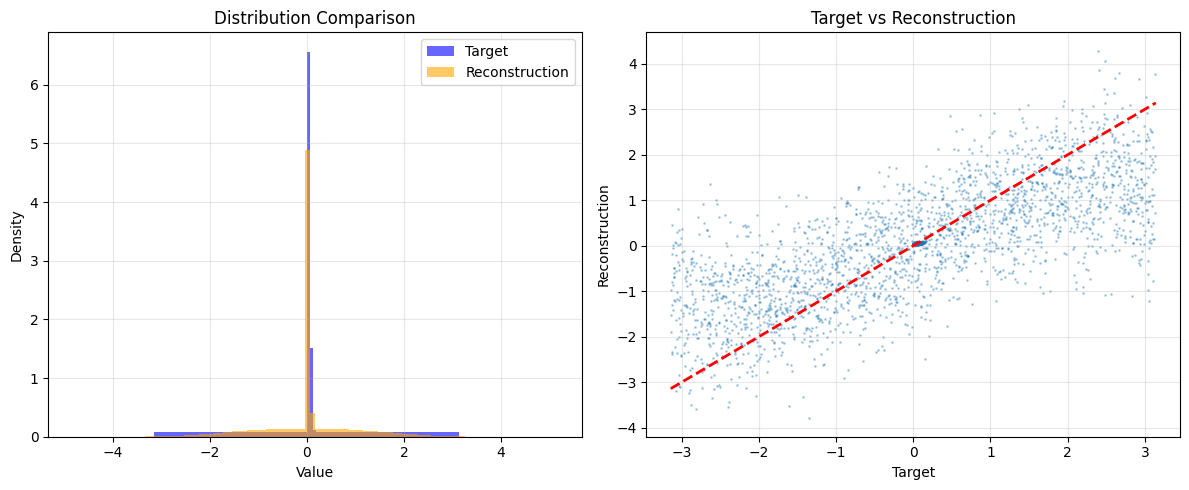

Target   - Mean: 0.0213, Std: 1.2819
Recon    - Mean: 0.0216, Std: 0.9143
MSE: 0.790993
Correlation: 0.7202


In [4]:
import matplotlib.pyplot as plt
import numpy as np
target = output['target'].detach().cpu().numpy().flatten()
recon = output['reconstruction'].detach().cpu().numpy().flatten()

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(target, bins=100, alpha=0.6, label='Target', color='blue', density=True)
plt.hist(recon, bins=100, alpha=0.6, label='Reconstruction', color='orange', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter
plt.subplot(1, 2, 2)
sample_idx = np.random.choice(len(target), min(5000, len(target)), replace=False)
plt.scatter(target[sample_idx], recon[sample_idx], alpha=0.3, s=1)
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--', linewidth=2)
plt.xlabel('Target')
plt.ylabel('Reconstruction')
plt.title('Target vs Reconstruction')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Target   - Mean: {target.mean():.4f}, Std: {target.std():.4f}")
print(f"Recon    - Mean: {recon.mean():.4f}, Std: {recon.std():.4f}")
print(f"MSE: {np.mean((recon - target)**2):.6f}")
print(f"Correlation: {np.corrcoef(target, recon)[0, 1]:.4f}")